# Get regional models and their add_flowing_data
mThis file prepares the regonal_grids folder and stores the regional grids
minfo therein as a geopackage for layer use. It generates a GeoDataFrame with
mthe regional grid properties, adding its convex hull, its centroid and the
mlayer properties (k, k33, ss, and sy)
mFunctions are given to scan projects carried out with the Flamish
m"Grondwatersimulator" and # find out which regional models it contains.
mFor this it use Modflows binary .grb files of the regional models
mthat first were generated by Modflow6 after removing the NOGRB
moption from the no_permits.disv file in the regional directory of each project.
mThe regional model data are put in a seaparate data/regional_models folder
mfor easy later use.
mThese .grb files are used to get the cell vertices and around
meach model a convex hull is generated and their centroid is computed.
mThe subsurface info of ech regional model (k, k33, ss and sy) is also
mextracted from the specific projects folder, added to a GeoDataFrame
mand written to diskin the data/regional_models folder as a geopackage.
mThe grondwatersimulator contains for Flanders three regional models.
mThe k, k33, ss and sy data of each of them is layered, i.e. has
ma constant value for each layer througout the entire regional model.
mTO 2025-10-24

In [5]:
import os
import sys

from pathlib import Path

sys.path.insert(0, str(Path(os.getcwd()).parent))
sys.path

import numpy as np
import geopandas as gpd
from src import vtl_grids_fr_projects as gfp
from flopy.mf6.utils import MfGrdFile
from glob import glob
from pathlib import Path
import etc

# --- essential folders
try:
    projects_folder = os.path.join(os.getcwd(), '../data', '6194_GWS_testen')
    assert os.path.isdir(projects_folder), f"Path not found <{projects_folder}>"
except Exception as e:
    projects_folder = os.path.join(os.getcwd(), 'data', '6194_GWS_testen')
    assert os.path.isdir(projects_folder), f"Path not found <{projects_folder}>"
    
images_folder = os.path.join(projects_folder, '../../images/vtl_fdm')
assert os.path.isdir(images_folder), "No such folder <{images_folder}>"

# Get regional grid data
    
1. Scan all projects and set which regional model each uses.
2. For each regional model select the first project using it.
3. Get the .grb file and compute centroid and convec hull.
4. Get npf and sto file and get k, k33, ss and sy
5. All these data is put in a dictionary
6. This dict is converted to GeoDataFrame
7. The convex hull of each of the three regional models is plotted
8. A label and centroid are added to the plot
9.  This GeoDataFrame is saved to disk as geopckage

Processing <Rapport HH_212_filterbemaling>
Processing <Rapport GK_211_open_bemaling>
Processing <Rapport LC_213_bronbemaling>
Processing <Rapport HH_213_bronbemaling>
Processing <Rapport GK_213_bronbemaling>
Processing <Rapport BM_211_open_bemaling>
Processing <Rapport BM_213_bronbemaling>
Processing <Rapport BM_216_retourbemaling_bronnen>
Processing <Rapport GK_212_filterbemaling>
Processing <Rapport BM_4_verharding>
Processing <Rapport BM_12_permanente_winning>
Processing <Rapport LC_12_permanente_winning>
Processing <Rapport GK_221_lijnbemaling_filters>
Processing <Rapport BP_212_filterbemaling>
Processing <Rapport BP_3_permanente_bemaling>
Processing <Rapport LC_212_filterbemaling>
Processing <Rapport BP_221_lijnbemaling_filters>
Processing <Rapport BP_11_seizoenale_winning>
Processing <Rapport BP_211_open_bemaling>
Processing <Rapport LC_211_open_bemaling>
Processing <Rapport HH_12_permanente_winning>
Processing <Rapport HH_221_lijnbemaling_filters>
Processing <Rapport GK_12_perma

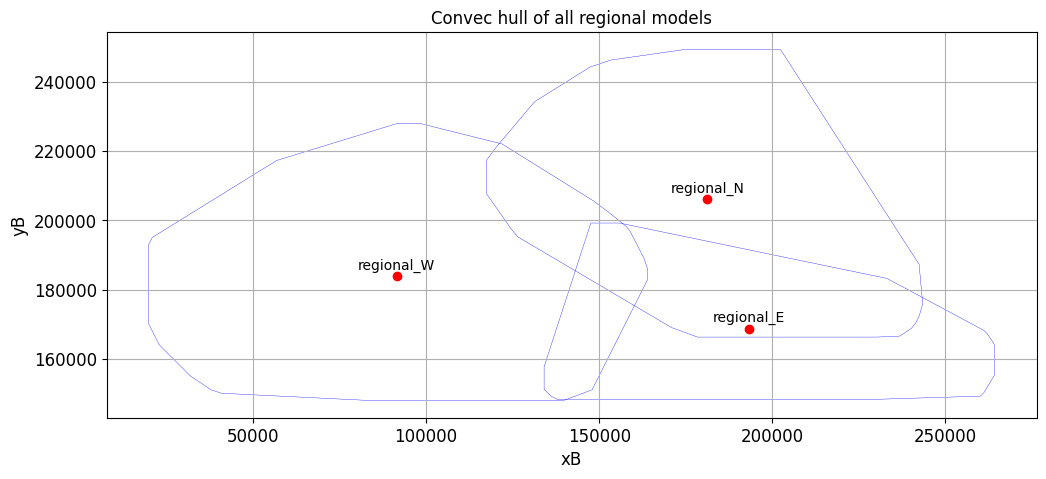

In [7]:
# --- Get regional model data (k, k33, ss, sy) and plot their convec hull

# --- get gdf with regional model data for all projects (convex_hull geometry)
gdf_reg_all_cases = gfp.get_reg_gdf_all_projects(projects_folder)

gdf_reg_data = gfp.gdf_and_regional_model_gpkg(projects_folder, gdf_reg_all_cases)

ax = etc.newfig("Convec hull of all regional models", "xB", "yB")

gdf_reg_data.plot(ax=ax, fc='none', ec='b', linewidth=0.25)

# --- plot centroid and label with model name
shift_y = 1000. # m shift label up

for id in gdf_reg_data.index:
    rec = gdf_reg_data.loc[id]
    xC, yC = rec['xC'], rec['yC']
    ax.text(xC, yC + shift_y, rec['model_type'], ha='center', va='bottom')
    
    ax.plot(xC, yC, 'ro', label='Centroid of regional model')
    
ax.figure.savefig(os.path.join(images_folder, 'regional_convex_hull.png'))

# Show the grid of each of the 3 regional models

1. Get the three regional model grid files (.grb) in the regional_models directory
1. Plot their convec hull.
1. Plot a label
1. Plot the vertices of each model in a different colot.


,model,xC,yC,geometry
0,region_west.disv.grb,91482.0,183779.0,"POLYGON ((81933.877 148054.071, 40933.877 1500..."


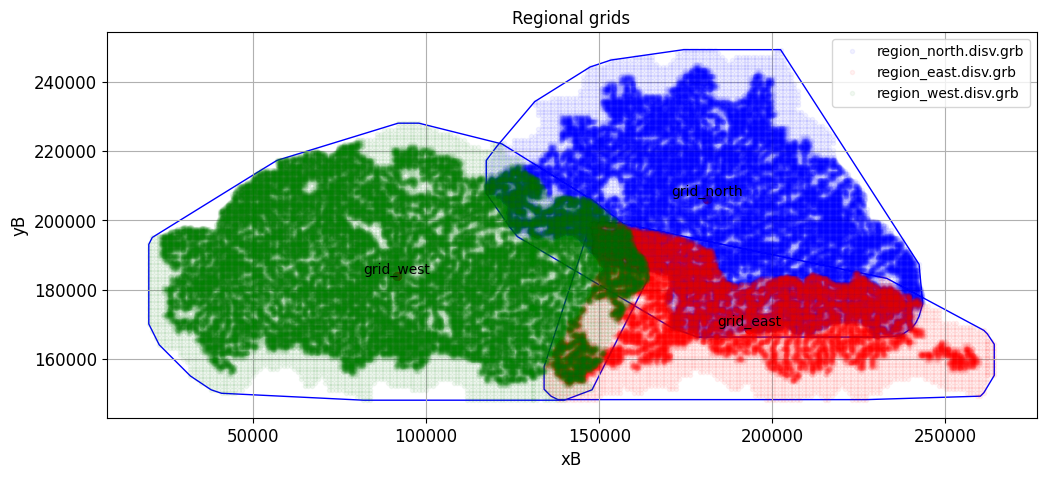

In [9]:
# %% --- plot the grid of the three regional models
clrs = etc.color_cycler()

grds = []

ax = etc.newfig("Regional grids", "xB", "yB")

# --- use the grid (.grb) files of the regional models
for grb_file in glob(os.path.join(projects_folder, '../regional_grids') + '/*.grb'):
        clr = next(clrs)

        # --- Get regional grid's convec hull and centroid
        reg_grd = gfp.get_grid(grb_file, crs="EPSG:31370", ax=ax)

        # --- Get full grid to allow plotting the grid vertices
        gr = MfGrdFile(grb_file)
        ax.plot(*gr.verts.T, '.', color=clr, lw=0.1, alpha=0.05,
                label=os.path.basename(grb_file))

        # --- Get the centroid's coordinates
        xC, yC = float(reg_grd.centroid.x[0]), float(reg_grd.centroid.y[0])

        # --- Plot label
        ax.text(xC, yC,
                reg_grd['model'][0].replace('.disv.grb', '').replace('region', 'grid'),
                        ha='center', va='bottom')

grds.append(reg_grd)

ax.legend()

ax.figure.savefig(os.path.join(images_folder, 'regional_grids.png'))

# --- All grds in a GeoDataFrame
grds = gpd.pd.concat(grds, ignore_index=True)
grds

# Conclusion

1. There are three regional models as proven by the convec hulls.
2. They are called here 'W', 'E' and 'N'
